<a href="https://colab.research.google.com/github/raudh1/LorenzModel/blob/main/GenerateTrajLorenzRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GENERATE TRAJ

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from random import randint
import os
import sys
import string
#from torch import Dataset, Dataloader
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np



In [5]:
from matplotlib import pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set files and directories

In [7]:
torch.set_default_tensor_type('torch.DoubleTensor')
mypath="./drive/MyDrive/exp/"

dirName = './RESULTS'
if not os.path.exists(dirName):
    os.makedirs(dirName)

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')

print("device=",device)

device= cpu


In [8]:
#DEFINE RNN

class Sequence(nn.Module):
    def __init__(self, hidden, layer, features, dropout):
        super(Sequence, self).__init__()
        self.hidden   = hidden
        self.layer    = layer
        self.features = features
        self.h_0 =torch.normal(mean=0.0, std=torch.ones(layer,1, hidden, dtype=torch.double)).to(device)

        self.rnn  = nn.RNN(self.features, self.hidden, self.layer, dropout=dropout)
        self.linear = nn.Linear(self.hidden, self.features)
 
    def forward(self, input, h_t=None):
        if h_t is None:
          h_t=self.h_0
        self.rnn.flatten_parameters()
        out, h_t = self.rnn(input, h_t)
        output = out.view(input.size(0)*input.size(1),self.hidden)
        output = self.linear(output)
        output = output.view(input.size(0),input.size(1),self.features)
        return output , h_t


    def predict(self, init_points,N=100, h_t=None):
        if h_t is None:
          h_t=self.h_0
        
        init_pred, h_t = self.forward(init_points, h_t)
        output=torch.zeros(init_pred.shape[0]+N,1,self.features)
        output[:init_pred.shape[0]]=init_pred
        inp = init_pred[-1].unsqueeze(0)
        
        for i in range(init_pred.shape[0],N+init_pred.shape[0]):

          inp, h_t =self.forward(inp,h_t)
          output[i]=inp

        return output


In [9]:
if __name__ == '__main__':
    np.random.seed(0)
    # load data and make training set
    hidden   = 100
    layer    = 1
    features = 3
    dropout  = 0
    # build the model
    case = 'FULL'
        
    ini = 25


In [2]:
def load_data(case,sampling=10,start=0):

  if (case=='MANI'or case=='PART' ):

    name=mypath+'/'+case+'_'+str(k)+'.npy'
    data = np.load(name).astype('float64')
    data=np.moveaxis(data,-1,0)
    data=data[::sampling,:1,:]                    # one of 9 trajectories and sampling
    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8
    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data

  elif (case=='other'):
    name= mypath+'/other_traj.npy'
    data = np.load(name).astype('float64')
    data=np.moveaxis(data,-1,0)
    data=data[::sampling,:1,:]

    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8

    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data
     
  elif (case=='zero'):
    name=mypath+'/zeros_traj.npy'
    data = np.load(name).astype('float64')

    data=np.moveaxis(data,-1,0)
    data=data[::sampling,:1,:]

    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8

    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data

  elif (case=='FULL'):
    name=mypath+'/'+case+'_'+str(k)+'.npy'
    data = np.load(name).astype('float64')
    data = np.expand_dims(data.T, axis=1)
    data=data[::sampling,:1,:]

    N=(len(data)*3)//4
    V=len(data)//8
    T=len(data)//8

    train_data = torch.from_numpy(data[start:start+N,:,:]).double().to(device)
    valid_data = torch.from_numpy(data[start+N:start+N+V,:,:]).double().to(device)
    test_data = torch.from_numpy(data[start+N+V:start+N+V+T,:,:]).double().to(device)

    return train_data, valid_data, test_data

In [43]:
k=0

train_data, valid_data, test_data=load_data(case,2)
print(train_data.shape)


seq = Sequence(hidden,layer,features,dropout).double().to(device)

def train(model,train_data,valid_data,lr=0.05,epoch=300):

      print('input shape=',train_data.shape," target shape =",valid_data.shape)
      criterion = nn.MSELoss()
      optimizer = optim.Adam(model.parameters(), lr) #learning rate fixed#
  
  
      err = 10
      loss1 = 1
      i = 0
      valid_loss=[]
      loss_grad=[]
      train_loss= []
      i=0
      
      min_perf = 90000
      while i<epoch: 
          model.train()
          optimizer.zero_grad()
          out,_ =model(train_data[:-1]) #INPUT
          loss = criterion(out, train_data[1:]) # OUTPUT
          loss.backward()

          train_loss.append(loss.item())

          optimizer.step()
          # validation
          with torch.no_grad():
            model.eval()
            pred,_ = model(valid_data[:-1])
            validloss = criterion(pred, valid_data[1:])
            valid_loss.append(validloss.item())
     
          if i%(50)==0:
              loss2 = loss
              err = np.abs(loss2.item()-loss1)/10
              loss1 = loss2.item()
              print(i, "train loss", train_loss[-1], "valid loss",
                  valid_loss[-1])
          i += 1
          sys.stdout.flush()
          if validloss.item() < min_perf :
            min_perf = validloss.item()
            torch.save(model.state_dict(), './param')
      
      print("last epoch: ", i)
      

      return train_loss, valid_loss

torch.Size([10125, 1, 3])


In [44]:
train_loss, valid_loss = train(seq,train_data,valid_data,lr=0.04,epoch=500)

input shape= torch.Size([10125, 1, 3])  target shape = torch.Size([1687, 1, 3])
0 train loss 266.7621050072111 valid loss 187.82997224812408
50 train loss 1.8631654409744742 valid loss 1.8904110408685566
100 train loss 0.20872482391312167 valid loss 0.3455498832604411
150 train loss 0.09114915805970725 valid loss 0.25724408473839944
200 train loss 0.4803687204849066 valid loss 0.28554256192457483
250 train loss 0.04261206508521444 valid loss 0.23688255954840887
300 train loss 0.02813977003753404 valid loss 0.23146195797508018
350 train loss 0.02120610684189275 valid loss 0.2297921643655847
400 train loss 0.17182833049363844 valid loss 0.26674603062672425
450 train loss 0.018288912411175175 valid loss 0.23442386468891754
last epoch:  500


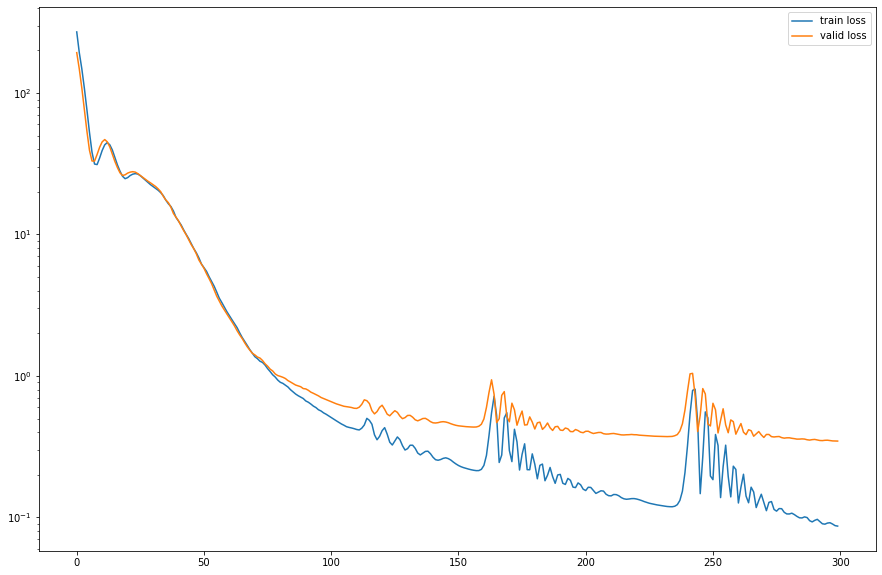

In [21]:
plt.figure(figsize=(15,10))

plt.plot(train_loss,label='train loss')
plt.plot(valid_loss,label='valid loss')
plt.semilogy()
plt.legend()
plt.show()

In [218]:
input=train_data   

   # Chose dataset you want to compare the model with
history=3000
future=1000
def generate_traj(model,inp,h,f): # h is history and f is future inp is input that can be train or test or validation set
  traj_1step ,_=  model(inp[:h+f])  # 1 step
  traj = model.predict(inp[:h],N=f) #generated

  return traj_1step.detach().numpy(), traj.detach().numpy()

**PLOT FUNCTIONS**

In [319]:
def plot_traj(traj_1step,traj,h,coordinate='x',data=False,error=False): # h is history traj is generated traj
  if coordinate=='x':
    i=0
  if coordinate=='y':
    i=1
  if coordinate=='z':
    i=2

  plt.figure(figsize=(14.4,8.8))
  plt.plot(traj_1step[:,0,i],label='1step model')
  plt.plot(traj[:,0,i],label='traj_generate')
  if data is True:
    plt.plot(input[:,0,i],label='real data')
  if error is True:
    print(np.mean(np.power(traj_1step[h:h+future,0,i]-traj[h:h+future,0,i],2)))
  plt.scatter(h,traj_1step[h,0,i],color='red')

  plt.xlim(h-100,len(traj))
  plt.ylabel(rf'${coordinate}(t)$',fontsize=20)
  plt.xlabel(r'$t$',fontsize=20)
  plt.legend()
  plt.show()
  print(traj_1step.shape, traj.shape)
  print(np.linalg.norm(traj_1step-traj))

def plot_traj_3D(traj,traj_1step,inp,h=1000,f=10,data=False):
  fig = plt.figure(figsize=(20,15))
  ax = fig.gca(projection="3d")
  start=h

  ax.plot(traj_1step[start:start+f,0,0],traj_1step[start:start+f,0,1],traj_1step[start:start+f,0,2],label='1 step traj',linestyle='--')
  ax.plot(traj[start:start+f,0,0],traj[start:start+f,0,1],traj[start:start+f,0,2],label='generated traj')
  
  if data is True:
    ax.plot(inp[start:h+f,0,0],inp[start:h+f,0,1],inp[start:h+f,0,2],label='real traj')

  
  ax.scatter3D(traj_1step[h,0,0],traj_1step[h,0,1],traj_1step[h,0,2],c='green',label='starting point')
  ax.set_xlabel(r'$x$',fontsize=30)
  ax.set_ylabel(r'$y$',fontsize=30)
  ax.set_zlabel(r'$z$',fontsize=30)

  ax.legend(fontsize=15)

In [234]:
traj_1step_last_model, traj_generated_last_model=generate_traj(inp=input,model=seq,h=history,f=future)

111.91614842470919


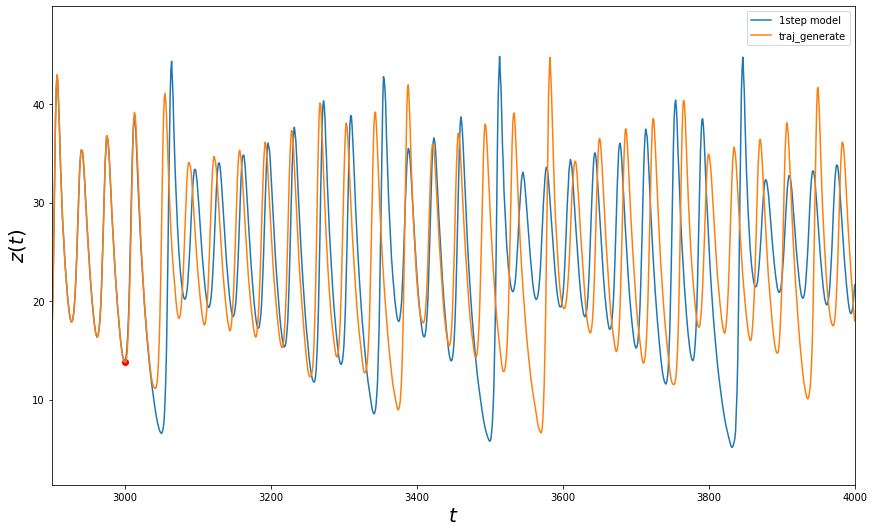

(4000, 1, 3) (4000, 1, 3)
522.578759844988


In [322]:
plot_traj(traj_1step_last_model,traj_generated_last_model,coordinate='z',data=False,h=history,error=True)

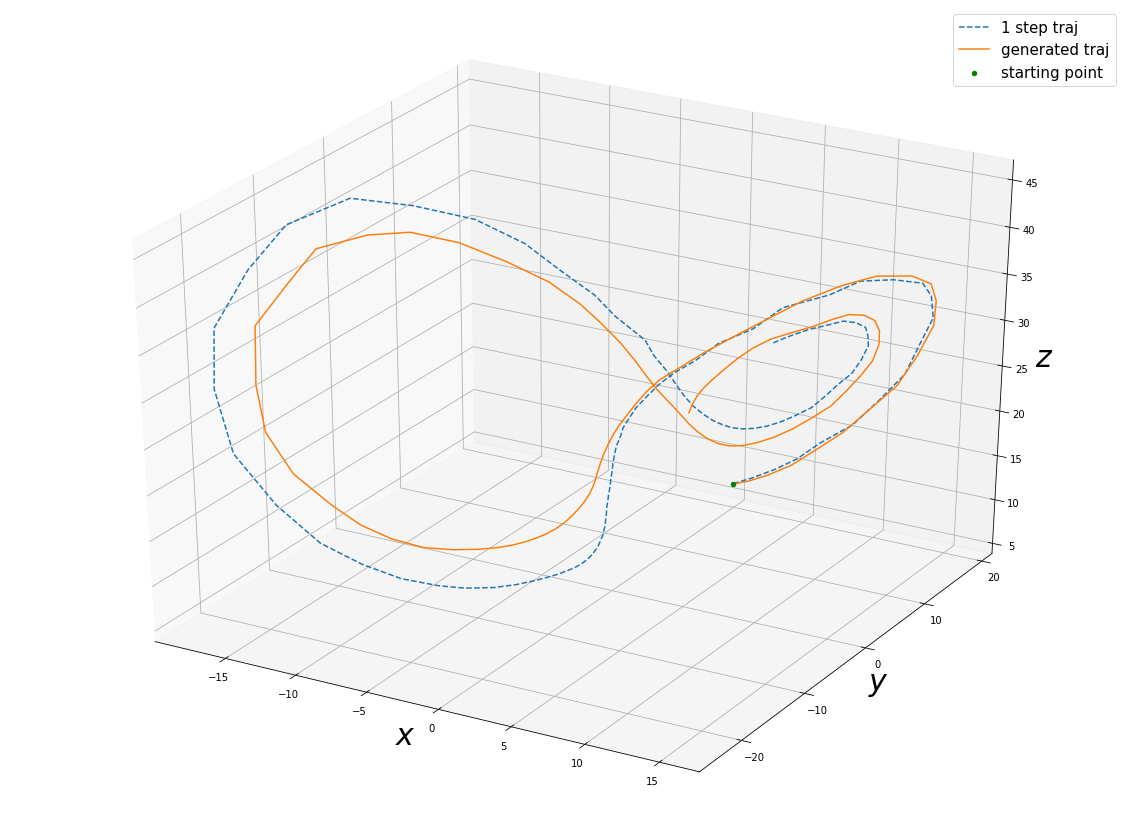

In [236]:
plot_traj_3D(traj_generated_last_model,traj_1step_last_model,inp=train_data,h=history,f=100,data=False) # plot 'future' points after 'history' points

Comparison with best model (min validation loss) 

In [257]:
bestmdl = Sequence(hidden,layer,features,dropout)
bestmdl.load_state_dict(torch.load('./param'))

best_traj_1step , best_traj=  generate_traj(bestmdl,inp=test_data,h=1000,f=600)

In [258]:
test_data.shape

torch.Size([1687, 1, 3])

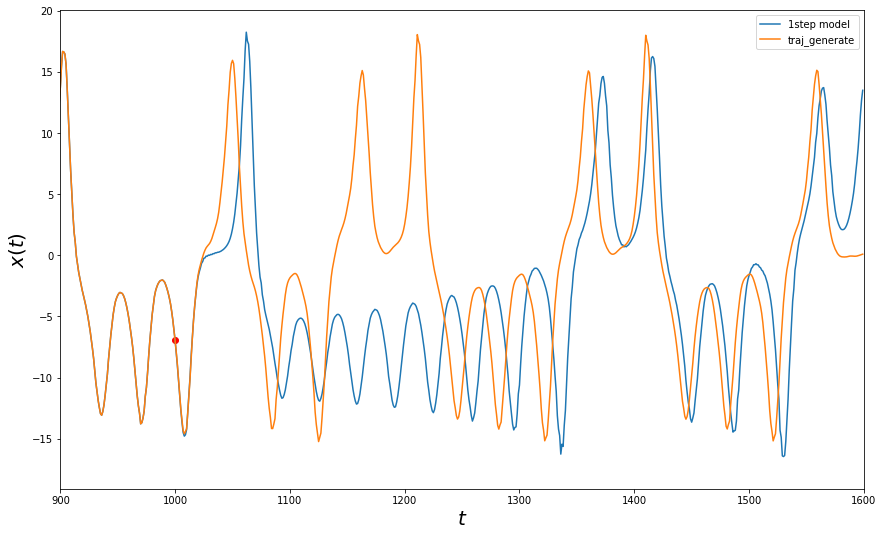

(1600, 1, 3) (1600, 1, 3)
428.5653313547668


In [259]:
plot_traj(best_traj_1step,best_traj,h=1000)

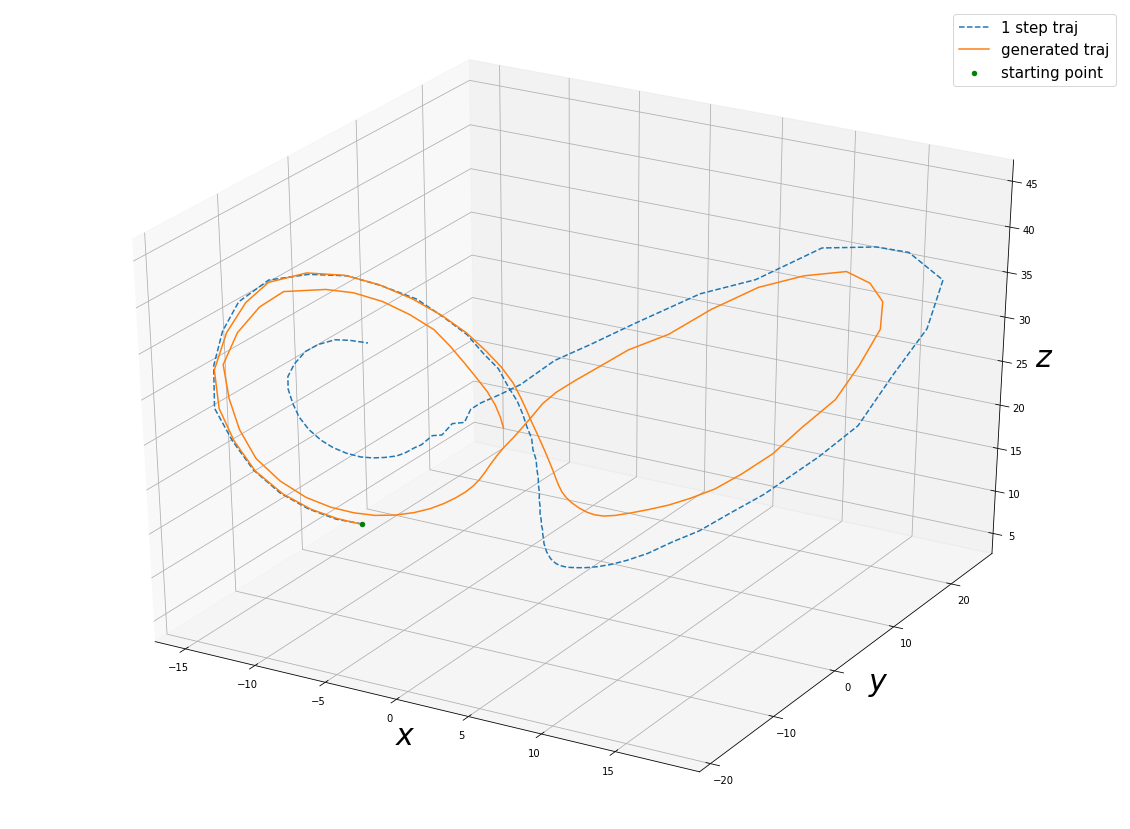

In [263]:
plot_traj_3D(best_traj,best_traj_1step,h=1000,f=100,inp=test_data)